In [1]:
import pandas as pd
import numpy as np
import copy as cp
from typing import Tuple
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import normalize,StandardScaler
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV,train_test_split,KFold
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score,f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss,roc_auc_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import shap
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
Dataset = pd.read_csv("Dataset_Final.csv")

In [3]:
Dataset.isnull().sum()

Unnamed: 0                        0
Hospital_Name                     0
Age                               0
BMI                               0
LOS                               0
Average_Daily_Use_Cigarettes      0
Hookah_Consumption                0
SystolicBP                        0
DiastolicBP                       0
Respiratory_rate                  0
Oxygen_Saturation_Percent         0
Intubation_Duration_Day           0
ICU_LOS                           0
Total_Lung_Involvement_Percent    0
NIV_Duration_Day                  0
Total_Lung_Involvement_Rank       8
Sex                               0
Current_Smoking                   0
History_hookah                    0
Drug_history                      0
Sweating                          0
Fever                             0
Dyspnea                           0
Chestpain                         0
Abnormal_Lung_Signs               0
Diabetes                          0
Hypertension                      0
Cancers                     

In [4]:
Dataset.drop("Unnamed: 0", axis = 1 , inplace=True)
Dataset.drop("Hospital_Name", axis = 1 , inplace=True)
Dataset.drop("Total_Lung_Involvement_Rank", axis = 1 , inplace=True)
Dataset.drop("Hookah_Consumption", axis = 1 , inplace=True)
Dataset.drop("LOS", axis = 1 , inplace=True)
Dataset.drop("ICU_LOS", axis = 1 , inplace=True)
Dataset.head()

,Age,BMI,Average_Daily_Use_Cigarettes,SystolicBP,DiastolicBP,Respiratory_rate,Oxygen_Saturation_Percent,Intubation_Duration_Day,Total_Lung_Involvement_Percent,NIV_Duration_Day,...,Cancers,Cardiovascular_Disease,CKD,COPD,Immunosuppressant_Drugs,Antihypertensive_drug,Pantoprazole,Hospitalization_14_days_ago,ICU_admission,Death
0,61.0,20.500000,0.0,122.422697,78.0,19.718638,91.0,0,0.0,0,...,0,0,0,0,0,1,0,0.0,1.0,1
1,74.0,26.700000,0.0,40.000000,75.0,16.000000,75.0,0,0.0,0,...,0,1,1,0,0,0,1,1.0,1.0,1
2,51.0,29.100000,0.0,122.422697,78.0,19.718638,91.0,0,0.0,0,...,0,0,0,0,0,0,0,1.0,1.0,1
3,64.0,41.000000,0.0,136.000000,78.0,20.000000,95.0,0,0.0,0,...,0,0,0,0,0,0,0,0.0,1.0,0
4,20.0,26.148507,0.0,113.000000,76.0,19.000000,92.0,0,0.0,0,...,0,0,0,0,0,0,0,0.0,2.0,1


In [5]:
list(Dataset.columns)

['Age',
 'BMI',
 'Average_Daily_Use_Cigarettes',
 'SystolicBP',
 'DiastolicBP',
 'Respiratory_rate',
 'Oxygen_Saturation_Percent',
 'Intubation_Duration_Day',
 'Total_Lung_Involvement_Percent',
 'NIV_Duration_Day',
 'Sex',
 'Current_Smoking',
 'History_hookah',
 'Drug_history',
 'Sweating',
 'Fever',
 'Dyspnea',
 'Chestpain',
 'Abnormal_Lung_Signs',
 'Diabetes',
 'Hypertension',
 'Cancers',
 'Cardiovascular_Disease',
 'CKD',
 'COPD',
 'Immunosuppressant_Drugs',
 'Antihypertensive_drug',
 'Pantoprazole',
 'Hospitalization_14_days_ago',
 'ICU_admission',
 'Death']

In [6]:
#Controlling Outlier data
data_mean, data_std = np.mean(Dataset['Age']), np.std(Dataset['Age'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
outliers = [x for x in Dataset['Age'] if x < lower or x > upper]
print('Age Column Identified outliers: %d' % len(outliers))
#############################################################################################
data_mean, data_std = np.mean(Dataset['BMI']), np.std(Dataset['BMI'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
outliers = [x for x in Dataset['BMI'] if x < lower or x > upper]
print('BMI Column Identified outliers: %d' % len(outliers))


for i in range(len(Dataset['BMI'])):
    if Dataset['BMI'][i] < lower:
        Dataset['BMI'][i] = lower
        
        
for i in range(len(Dataset['BMI'])):
    if Dataset['BMI'][i] > upper:
        Dataset['BMI'][i] = upper
        

outliers = [x for x in Dataset['BMI'] if x < lower or x > upper]
print('BMI Column Identified outliers: %d' % len(outliers))
#############################################################################################
data_mean, data_std = np.mean(Dataset['Average_Daily_Use_Cigarettes']), np.std(Dataset['Average_Daily_Use_Cigarettes'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
outliers = [x for x in Dataset['Average_Daily_Use_Cigarettes'] if x < lower or x > upper]
print('Average_Daily_Use_Cigarettes Column Identified outliers: %d' % len(outliers))

for i in range(len(Dataset['Average_Daily_Use_Cigarettes'])):
    if Dataset['Average_Daily_Use_Cigarettes'][i] < lower:
        Dataset['Average_Daily_Use_Cigarettes'][i] = lower
        
        
for i in range(len(Dataset['Average_Daily_Use_Cigarettes'])):
    if Dataset['Average_Daily_Use_Cigarettes'][i] > upper:
        Dataset['Average_Daily_Use_Cigarettes'][i] = upper
        

outliers = [x for x in Dataset['Average_Daily_Use_Cigarettes'] if x < lower or x > upper]
print('Average_Daily_Use_Cigarettes Column Identified outliers: %d' % len(outliers))
#############################################################################################
data_mean, data_std = np.mean(Dataset['SystolicBP']), np.std(Dataset['SystolicBP'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
outliers = [x for x in Dataset['SystolicBP'] if x < lower or x > upper]
print('SystolicBP Column Identified outliers: %d' % len(outliers))

for i in range(len(Dataset['SystolicBP'])):
    if Dataset['SystolicBP'][i] < lower:
        Dataset['SystolicBP'][i] = lower
        
        
for i in range(len(Dataset['SystolicBP'])):
    if Dataset['SystolicBP'][i] > upper:
        Dataset['SystolicBP'][i] = upper
        

outliers = [x for x in Dataset['SystolicBP'] if x < lower or x > upper]
print('SystolicBP Column Identified outliers: %d' % len(outliers))
#############################################################################################
data_mean, data_std = np.mean(Dataset['DiastolicBP']), np.std(Dataset['DiastolicBP'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
outliers = [x for x in Dataset['DiastolicBP'] if x < lower or x > upper]
print('DiastolicBP Column Identified outliers: %d' % len(outliers))

for i in range(len(Dataset['DiastolicBP'])):
    if Dataset['DiastolicBP'][i] < lower:
        Dataset['DiastolicBP'][i] = lower
       

for i in range(len(Dataset['DiastolicBP'])):
    if Dataset['DiastolicBP'][i] > upper:
        Dataset['DiastolicBP'][i] = upper
    

outliers = [x for x in Dataset['DiastolicBP'] if x < lower or x > upper]
print('DiastolicBP Column Identified outliers: %d' % len(outliers))
#############################################################################################
data_mean, data_std = np.mean(Dataset['Respiratory_rate']), np.std(Dataset['Respiratory_rate'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
outliers = [x for x in Dataset['Respiratory_rate'] if x < lower or x > upper]
print('Respiratory_rate Column Identified outliers: %d' % len(outliers))

for i in range(len(Dataset['Respiratory_rate'])):
    if Dataset['Respiratory_rate'][i] < lower:
        Dataset['Respiratory_rate'][i] = lower
 
        
for i in range(len(Dataset['Respiratory_rate'])):
    if Dataset['Respiratory_rate'][i] > upper:
        Dataset['Respiratory_rate'][i] = upper
   

outliers = [x for x in Dataset['Respiratory_rate'] if x < lower or x > upper]
print('Respiratory_rate Column Identified outliers: %d' % len(outliers))
#############################################################################################
data_mean, data_std = np.mean(Dataset['Oxygen_Saturation_Percent']), np.std(Dataset['Oxygen_Saturation_Percent'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
outliers = [x for x in Dataset['Oxygen_Saturation_Percent'] if x < lower or x > upper]
print('Oxygen_Saturation_Percent Column Identified outliers: %d' % len(outliers))

for i in range(len(Dataset['Oxygen_Saturation_Percent'])):
    if Dataset['Oxygen_Saturation_Percent'][i] < lower:
        Dataset['Oxygen_Saturation_Percent'][i] = lower

        
for i in range(len(Dataset['Oxygen_Saturation_Percent'])):
    if Dataset['Oxygen_Saturation_Percent'][i] > upper:
        Dataset['Oxygen_Saturation_Percent'][i] = upper


outliers = [x for x in Dataset['Oxygen_Saturation_Percent'] if x < lower or x > upper]
print('Oxygen_Saturation_Percent Column Identified outliers: %d' % len(outliers))
#############################################################################################
data_mean, data_std = np.mean(Dataset['Intubation_Duration_Day']), np.std(Dataset['Intubation_Duration_Day'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
outliers = [x for x in Dataset['Intubation_Duration_Day'] if x < lower or x > upper]
print('Intubation_Duration_Day Column Identified outliers: %d' % len(outliers))

for i in range(len(Dataset['Intubation_Duration_Day'])):
    if Dataset['Intubation_Duration_Day'][i] < lower:
        Dataset['Intubation_Duration_Day'][i] = lower

        
for i in range(len(Dataset['Intubation_Duration_Day'])):
    if Dataset['Intubation_Duration_Day'][i] > upper:
        Dataset['Intubation_Duration_Day'][i] = upper


outliers = [x for x in Dataset['Intubation_Duration_Day'] if x < lower or x > upper]
print('Intubation_Duration_Day Column Identified outliers: %d' % len(outliers))
#############################################################################################
data_mean, data_std = np.mean(Dataset['Total_Lung_Involvement_Percent']), np.std(Dataset['Total_Lung_Involvement_Percent'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
outliers = [x for x in Dataset['Total_Lung_Involvement_Percent'] if x < lower or x > upper]
print('Total_Lung_Involvement_Percent Column Identified outliers: %d' % len(outliers))

for i in range(len(Dataset['Total_Lung_Involvement_Percent'])):
    if Dataset['Total_Lung_Involvement_Percent'][i] < lower:
        Dataset['Total_Lung_Involvement_Percent'][i] = lower

        
for i in range(len(Dataset['Total_Lung_Involvement_Percent'])):
    if Dataset['Total_Lung_Involvement_Percent'][i] > upper:
        Dataset['Total_Lung_Involvement_Percent'][i] = upper


outliers = [x for x in Dataset['Total_Lung_Involvement_Percent'] if x < lower or x > upper]
print('Total_Lung_Involvement_Percent Column Identified outliers: %d' % len(outliers))
#############################################################################################
data_mean, data_std = np.mean(Dataset['NIV_Duration_Day']), np.std(Dataset['NIV_Duration_Day'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
outliers = [x for x in Dataset['NIV_Duration_Day'] if x < lower or x > upper]
print('NIV_Duration_Day Column Identified outliers: %d' % len(outliers))

for i in range(len(Dataset['NIV_Duration_Day'])):
    if Dataset['NIV_Duration_Day'][i] < lower:
        Dataset['NIV_Duration_Day'][i] = lower

        
for i in range(len(Dataset['NIV_Duration_Day'])):
    if Dataset['NIV_Duration_Day'][i] > upper:
        Dataset['NIV_Duration_Day'][i] = upper


outliers = [x for x in Dataset['NIV_Duration_Day'] if x < lower or x > upper]
print('NIV_Duration_Day Column Identified outliers: %d' % len(outliers))

Age Column Identified outliers: 0
BMI Column Identified outliers: 8
BMI Column Identified outliers: 0
Average_Daily_Use_Cigarettes Column Identified outliers: 8
Average_Daily_Use_Cigarettes Column Identified outliers: 0
SystolicBP Column Identified outliers: 9
SystolicBP Column Identified outliers: 0
DiastolicBP Column Identified outliers: 9
DiastolicBP Column Identified outliers: 0
Respiratory_rate Column Identified outliers: 6
Respiratory_rate Column Identified outliers: 0
Oxygen_Saturation_Percent Column Identified outliers: 14
Oxygen_Saturation_Percent Column Identified outliers: 0
Intubation_Duration_Day Column Identified outliers: 13
Intubation_Duration_Day Column Identified outliers: 0
Total_Lung_Involvement_Percent Column Identified outliers: 30
Total_Lung_Involvement_Percent Column Identified outliers: 0
NIV_Duration_Day Column Identified outliers: 11
NIV_Duration_Day Column Identified outliers: 0



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [7]:
X = Dataset[Dataset.columns.difference(["Death"])] 
Y = Dataset["Death"]

In [8]:
sm = SMOTE(random_state=42)
X_balanced, Y_balanced = sm.fit_resample(X, Y)

In [9]:
X_balanced[['Age', 'BMI','Average_Daily_Use_Cigarettes',
       'SystolicBP', 'DiastolicBP', 'Respiratory_rate',
       'Oxygen_Saturation_Percent', 'Intubation_Duration_Day', 'Total_Lung_Involvement_Percent'
       ,'NIV_Duration_Day']] = normalize(X_balanced[['Age', 'BMI', 'Average_Daily_Use_Cigarettes',
       'SystolicBP', 'DiastolicBP', 'Respiratory_rate',
       'Oxygen_Saturation_Percent', 'Intubation_Duration_Day', 'Total_Lung_Involvement_Percent'
       ,'NIV_Duration_Day']])
X_balanced.head()

,Abnormal_Lung_Signs,Age,Antihypertensive_drug,Average_Daily_Use_Cigarettes,BMI,CKD,COPD,Cancers,Cardiovascular_Disease,Chestpain,...,Immunosuppressant_Drugs,Intubation_Duration_Day,NIV_Duration_Day,Oxygen_Saturation_Percent,Pantoprazole,Respiratory_rate,Sex,Sweating,SystolicBP,Total_Lung_Involvement_Percent
0,0,0.331393,1,0.0,0.111370,0,0,0,0,0,...,0,0.0,0.0,0.494373,0,0.107125,1.0,0,0.665082,0.0
1,0,0.504618,0,0.0,0.182071,1,0,0,1,0,...,0,0.0,0.0,0.511437,1,0.109106,1.0,0,0.420918,0.0
2,0,0.279945,0,0.0,0.159734,0,0,0,0,0,...,0,0.0,0.0,0.499511,0,0.108238,1.0,0,0.671994,0.0
3,0,0.322031,0,0.0,0.187998,0,0,0,0,0,...,0,0.0,0.0,0.478015,0,0.100635,1.0,0,0.684317,0.0
4,0,0.118566,0,0.0,0.155016,0,0,0,0,0,...,0,0.0,0.0,0.545404,0,0.112638,1.0,0,0.669898,0.0


In [10]:
X_balanced.isnull().sum()

Abnormal_Lung_Signs               0
Age                               0
Antihypertensive_drug             0
Average_Daily_Use_Cigarettes      0
BMI                               0
CKD                               0
COPD                              0
Cancers                           0
Cardiovascular_Disease            0
Chestpain                         0
Current_Smoking                   0
Diabetes                          0
DiastolicBP                       0
Drug_history                      0
Dyspnea                           0
Fever                             0
History_hookah                    0
Hospitalization_14_days_ago       0
Hypertension                      0
ICU_admission                     0
Immunosuppressant_Drugs           0
Intubation_Duration_Day           0
NIV_Duration_Day                  0
Oxygen_Saturation_Percent         0
Pantoprazole                      0
Respiratory_rate                  0
Sex                               0
Sweating                    

In [11]:
#Statistical Input
X = X_balanced[["Age", "Oxygen_Saturation_Percent", "Sweating", "Abnormal_Lung_Signs", "CKD",
             "Hospitalization_14_days_ago", "BMI", "Sex", "Current_Smoking", "Fever", "Chestpain",
               "Hypertension", "Cancers", "Cardiovascular_Disease", "Immunosuppressant_Drugs", 
                "Antihypertensive_drug", "Pantoprazole"]]
Y = Y_balanced

In [14]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel(), verbose=1)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [15]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100}
Best Score is : 0.8407577302072715 


0.808 + or -0.115 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.82 + or -0.114 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.822 + or -0.115 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.82 + or -0.117 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.826 + or -0.114 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.822 + or -0.121 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.832 + or -0.106 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.829 + or -0.108 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_d

In [16]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=100,
                   max_depth = 15, learning_rate = 0.1, colsample_bytree = 0.8)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.841
XGBoost average log_loss is 0.367
XGBoost average brier score is 0.117
XGBoost average auc is 0.914
XGBoost average recall is 0.815
XGBoost average precision is 0.849
XGBoost average f1 is 0.824


In [17]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVC(random_state=5),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [18]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best Score is : 0.7771151885830785 


0.66 + or -0.125 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.739 + or -0.095 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.59 + or -0.065 for the {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.636 + or -0.101 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.527 + or -0.031 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.622 + or -0.098 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.601 + or -0.088 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.521 + or -0.035 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.602 + or -0.09 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.602 + or -0.09 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.521 + or -0.035 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.601 + or -0.088 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.721 + or -0.114 for the {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.

In [19]:
svc = SVC(random_state=5, C = 100, gamma=1,kernel='rbf',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.777
SVC average log_loss is 0.475
SVC average brier score is 0.155
SVC average auc is 0.848
SVC average recall is 0.749
SVC average precision is 0.782
SVC average f1 is 0.759


In [27]:
#Statistical Input With Post admission variables
X = X_balanced[["Age", "Oxygen_Saturation_Percent", "Sweating", "Abnormal_Lung_Signs", "CKD",
             "Hospitalization_14_days_ago", "BMI", "Sex", "Current_Smoking", "Fever", "Chestpain",
               "Hypertension", "Cancers", "Cardiovascular_Disease", "Immunosuppressant_Drugs", 
                "Antihypertensive_drug", "Pantoprazole",'Intubation_Duration_Day','NIV_Duration_Day',
               "ICU_admission"]]
Y = Y_balanced

In [21]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel(), verbose=1)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [22]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 900}
Best Score is : 0.8970863064899761 


0.888 + or -0.118 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.884 + or -0.121 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.881 + or -0.127 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.882 + or -0.12 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.879 + or -0.124 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.89 + or -0.115 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.881 + or -0.13 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.879 + or -0.131 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_d

In [28]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=900,
                   max_depth = 10, learning_rate = 0.01, colsample_bytree = 0.3)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.897
XGBoost average log_loss is 0.257
XGBoost average brier score is 0.078
XGBoost average auc is 0.945
XGBoost average recall is 0.868
XGBoost average precision is 0.915
XGBoost average f1 is 0.886


In [24]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVC(random_state=5),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [25]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score is : 0.8242014950730546 


0.732 + or -0.135 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.803 + or -0.115 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.497 + or -0.005 for the {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.749 + or -0.084 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.77 + or -0.099 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.759 + or -0.091 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.701 + or -0.143 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.567 + or -0.068 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.686 + or -0.157 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.685 + or -0.157 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.567 + or -0.068 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.685 + or -0.157 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.8 + or -0.126 for the {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [26]:
svc = SVC(random_state=5, C = 100, gamma=0.1,kernel='rbf',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.824
SVC average log_loss is 0.428
SVC average brier score is 0.131
SVC average auc is 0.880
SVC average recall is 0.807
SVC average precision is 0.831
SVC average f1 is 0.816


C:\Users\alish\anaconda3\lib\site-packages\sklearn\calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


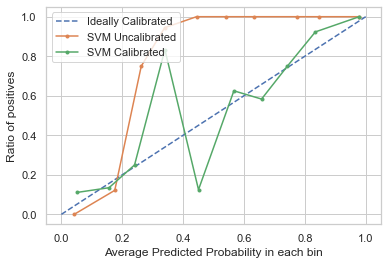

In [32]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.2, random_state=5)
calibrated = CalibratedClassifierCV(svc, method='sigmoid', cv=10)
calibrated.fit(xtrain, ytrain)
probs = calibrated.predict_proba(xtest)[:, 1]
uncalibrated = svc.decision_function(xtest)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(ytest, uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(ytest, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Ideally Calibrated')
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label = 'SVM Uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label = 'SVM Calibrated')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

In [33]:
calibrated = CalibratedClassifierCV(svc, method='sigmoid', cv=10)

scores_accuracy = cross_val_score(calibrated, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(calibrated, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(calibrated, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(calibrated, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(calibrated, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.842
SVC average log_loss is 0.386
SVC average brier score is 0.120
SVC average auc is 0.899
SVC average recall is 0.805
SVC average precision is 0.871
SVC average f1 is 0.835


In [10]:
#Feature Importance with extratreesclassifier Input
X = X_balanced[["Age" , "Oxygen_Saturation_Percent", "CKD","Respiratory_rate", "DiastolicBP", "SystolicBP",
                "BMI","Cancers","Average_Daily_Use_Cigarettes" ,"Fever", "Pantoprazole", "Abnormal_Lung_Signs",
                "Drug_history", "Current_Smoking", "Diabetes", "Cardiovascular_Disease" , "Dyspnea", "Hospitalization_14_days_ago",
                "Hypertension", "Antihypertensive_drug"]]
Y = Y_balanced

In [15]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel(), verbose=1)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [16]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 700}
Best Score is : 0.8720948012232416 


0.82 + or -0.122 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.823 + or -0.117 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.827 + or -0.109 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.837 + or -0.112 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.837 + or -0.105 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.835 + or -0.105 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.838 + or -0.108 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.844 + or -0.099 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max

In [11]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=700,
                   max_depth = 15, learning_rate = 0.01, colsample_bytree = 0.3)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.872
XGBoost average log_loss is 0.320
XGBoost average brier score is 0.097
XGBoost average auc is 0.939
XGBoost average recall is 0.843
XGBoost average precision is 0.891
XGBoost average f1 is 0.857


C:\Users\alish\anaconda3\lib\site-packages\sklearn\calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


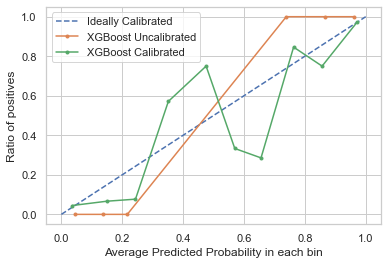

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.2, random_state=5)
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)
calibrated.fit(xtrain, ytrain)
probs = calibrated.predict_proba(xtest)[:, 1]
uncalibrated = xgb.predict_proba(xtest)[:,1]
fop_uncalibrated, mpv_uncalibrated = calibration_curve(ytest, uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(ytest, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Ideally Calibrated')
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label = 'XGBoost Uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label = 'XGBoost Calibrated')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

In [13]:
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)

scores_accuracy = cross_val_score(calibrated, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(calibrated, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(calibrated, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(calibrated, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(calibrated, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.864
XGBoost average log_loss is 0.314
XGBoost average brier score is 0.096
XGBoost average auc is 0.938
XGBoost average recall is 0.819
XGBoost average precision is 0.895
XGBoost average f1 is 0.843


In [27]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVC(random_state=5),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [28]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best Score is : 0.767940876656473 


0.655 + or -0.132 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.745 + or -0.097 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.492 + or -0.037 for the {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.64 + or -0.108 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.542 + or -0.043 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.643 + or -0.109 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.625 + or -0.111 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.529 + or -0.034 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.624 + or -0.11 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.625 + or -0.111 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.529 + or -0.034 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.625 + or -0.111 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.672 + or -0.113 for the {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0

In [14]:
svc = SVC(random_state=5, C = 100, gamma=1,kernel='rbf',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.768
SVC average log_loss is 0.499
SVC average brier score is 0.164
SVC average auc is 0.836
SVC average recall is 0.758
SVC average precision is 0.762
SVC average f1 is 0.751


In [14]:
#Feature Importance with extratreesclassifier Input + Post admission variables
X = X_balanced[["ICU_admission", "Age", "Oxygen_Saturation_Percent", "CKD", "DiastolicBP", "Respiratory_rate",
               "SystolicBP", "Intubation_Duration_Day", "BMI", "Cancers", "Dyspnea", "Drug_history", "Pantoprazole",
               "Abnormal_Lung_Signs", "Fever", "Cardiovascular_Disease", "Antihypertensive_drug", "Hypertension",
               "Hospitalization_14_days_ago", "Average_Daily_Use_Cigarettes"]]
Y = Y_balanced

In [31]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel(), verbose=1)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [32]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 300}
Best Score is : 0.9043068297655454 


0.871 + or -0.101 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.878 + or -0.098 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.879 + or -0.09 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.878 + or -0.097 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.882 + or -0.098 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.882 + or -0.101 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.888 + or -0.087 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.884 + or -0.096 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_

In [15]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=300,
                   max_depth = 15, learning_rate = 0.1, colsample_bytree = 0.3)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.904
XGBoost average log_loss is 0.268
XGBoost average brier score is 0.076
XGBoost average auc is 0.946
XGBoost average recall is 0.892
XGBoost average precision is 0.915
XGBoost average f1 is 0.899


C:\Users\alish\anaconda3\lib\site-packages\sklearn\calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


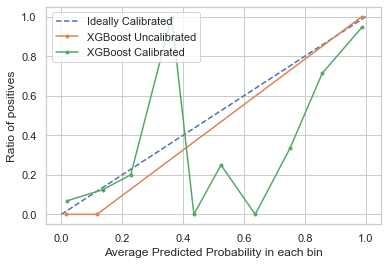

In [16]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.2, random_state=5)
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)
calibrated.fit(xtrain, ytrain)
probs = calibrated.predict_proba(xtest)[:, 1]
uncalibrated = xgb.predict_proba(xtest)[:,1]
fop_uncalibrated, mpv_uncalibrated = calibration_curve(ytest, uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(ytest, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Ideally Calibrated')
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label = 'XGBoost Uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label = 'XGBoost Calibrated')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

In [17]:
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)

scores_accuracy = cross_val_score(calibrated, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(calibrated, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(calibrated, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(calibrated, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(calibrated, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.902
XGBoost average log_loss is 0.282
XGBoost average brier score is 0.079
XGBoost average auc is 0.943
XGBoost average recall is 0.885
XGBoost average precision is 0.917
XGBoost average f1 is 0.896


In [34]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVC(random_state=5),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [35]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score is : 0.799277947672443 


0.74 + or -0.139 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.769 + or -0.111 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.449 + or -0.046 for the {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.748 + or -0.089 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.777 + or -0.102 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.736 + or -0.095 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.702 + or -0.14 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.614 + or -0.119 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.687 + or -0.158 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.687 + or -0.158 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.614 + or -0.119 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.687 + or -0.158 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.761 + or -0.124 for the {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [16]:
svc = SVC(random_state=5, C = 100, gamma=0.1,kernel='rbf',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.799
SVC average log_loss is 0.479
SVC average brier score is 0.146
SVC average auc is 0.856
SVC average recall is 0.803
SVC average precision is 0.795
SVC average f1 is 0.798


In [17]:
#RFECV with Logistic Regression Input
X = X_balanced[["Abnormal_Lung_Signs", "Antihypertensive_drug", "CKD", "COPD", "Cancers", "Cardiovascular_Disease", 
                "Chestpain", "Current_Smoking", "Diabetes", "Drug_history", "Dyspnea", "Fever", "History_hookah", 
                "Hospitalization_14_days_ago", "Hypertension", "Immunosuppressant_Drugs", "Oxygen_Saturation_Percent", 
                "Pantoprazole", "Sex", "Sweating"]]
Y = Y_balanced

In [10]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel(), verbose=1)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [11]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.5, 'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 900}
Best Score is : 0.8206082229018008 


0.801 + or -0.134 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.803 + or -0.13 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.801 + or -0.132 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.801 + or -0.126 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.801 + or -0.124 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.809 + or -0.141 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.805 + or -0.128 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.806 + or -0.126 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'ma

In [22]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=900,
                   max_depth = 10, learning_rate = 0.001, colsample_bytree = 0.5)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.821
XGBoost average log_loss is 0.529
XGBoost average brier score is 0.172
XGBoost average auc is 0.877
XGBoost average recall is 0.753
XGBoost average precision is 0.845
XGBoost average f1 is 0.779


In [ ]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


In [ ]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

In [18]:
svc = SVC(random_state=5, C = 100, gamma=0.1,kernel='rbf',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.732
SVC average log_loss is 0.548
SVC average brier score is 0.180
SVC average auc is 0.801
SVC average recall is 0.771
SVC average precision is 0.708
SVC average f1 is 0.736


In [19]:
#RFECV with Logistic Regression Input + Post admission variables
X = X_balanced[['Abnormal_Lung_Signs', 'Age', 'Antihypertensive_drug', 'BMI', 'CKD', 'COPD', 
                'Cancers', 'Cardiovascular_Disease', 'Chestpain', 'Current_Smoking', 'Diabetes', 
                'Drug_history', 'Dyspnea', 'Fever', 'History_hookah', 'Hospitalization_14_days_ago', 
                'Hypertension', 'ICU_admission', 'Immunosuppressant_Drugs', 'Intubation_Duration_Day', 
                'NIV_Duration_Day', 'Oxygen_Saturation_Percent', 'Pantoprazole', 'Sex', 'Sweating']]
Y = Y_balanced

In [11]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel(), verbose=1)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [12]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 900}
Best Score is : 0.9007645259938837 


0.883 + or -0.118 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.882 + or -0.127 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.884 + or -0.129 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.887 + or -0.122 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.886 + or -0.128 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.89 + or -0.128 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.885 + or -0.132 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.892 + or -0.126 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max

In [25]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=900,
                   max_depth = 15, learning_rate = 0.01, colsample_bytree = 0.3)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.901
XGBoost average log_loss is 0.251
XGBoost average brier score is 0.075
XGBoost average auc is 0.947
XGBoost average recall is 0.861
XGBoost average precision is 0.931
XGBoost average f1 is 0.885


In [14]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVC(random_state=5),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [15]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best Score is : 0.8195548759768944 


0.697 + or -0.122 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.794 + or -0.108 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.496 + or -0.003 for the {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.781 + or -0.101 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.786 + or -0.107 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.774 + or -0.103 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.751 + or -0.126 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.548 + or -0.056 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.703 + or -0.172 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.703 + or -0.172 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.548 + or -0.056 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.703 + or -0.172 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.805 + or -0.143 for the {'C': 1, 'gamma': 1, 'kernel': 'r

In [20]:
svc = SVC(random_state=5, C = 100, gamma=0.01,kernel='rbf',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.820
SVC average log_loss is 0.447
SVC average brier score is 0.138
SVC average auc is 0.875
SVC average recall is 0.818
SVC average precision is 0.825
SVC average f1 is 0.821


In [21]:
#RFECV with Gradient Boosting Input
X = X_balanced[["Age", "CKD", "Cancers", "DiastolicBP", "Oxygen_Saturation_Percent"]]
Y = Y_balanced

In [18]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel(), verbose=1)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [19]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 300}
Best Score is : 0.7962113489636425 


0.676 + or -0.038 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.668 + or -0.04 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.673 + or -0.04 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.673 + or -0.048 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.673 + or -0.047 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.67 + or -0.033 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.66 + or -0.04 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.662 + or -0.041 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_dep

In [28]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=300,
                   max_depth = 15, learning_rate = 0.01, colsample_bytree = 0.8)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.796
XGBoost average log_loss is 0.485
XGBoost average brier score is 0.156
XGBoost average auc is 0.850
XGBoost average recall is 0.817
XGBoost average precision is 0.785
XGBoost average f1 is 0.800


In [21]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVC(random_state=5),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [22]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'C': 100, 'gamma': 1, 'kernel': 'poly'}
Best Score is : 0.6743628950050969 


0.558 + or -0.062 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.55 + or -0.053 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.528 + or -0.059 for the {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.511 + or -0.026 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.496 + or -0.005 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.51 + or -0.031 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.51 + or -0.031 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.496 + or -0.005 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.51 + or -0.031 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.51 + or -0.031 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.496 + or -0.005 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.51 + or -0.031 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.66 + or -0.045 for the {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.65

In [22]:
svc = SVC(random_state=5, C = 100, gamma=1,kernel='poly',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.674
SVC average log_loss is 0.627
SVC average brier score is 0.216
SVC average auc is 0.724
SVC average recall is 0.679
SVC average precision is 0.676
SVC average f1 is 0.676


In [23]:
#RFECV with Gradient Boosting Input + Post admission variables
X = X_balanced[['Age', 'CKD', 'ICU_admission', 'Intubation_Duration_Day']]
Y = Y_balanced

In [25]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel(), verbose=1)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [26]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 900}
Best Score is : 0.8304960924226981 


0.816 + or -0.096 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.821 + or -0.099 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.82 + or -0.087 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.814 + or -0.087 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.811 + or -0.084 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.814 + or -0.094 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.815 + or -0.097 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.81 + or -0.089 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_d

In [31]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=900,
                   max_depth = 4, learning_rate = 0.01, colsample_bytree = 0.8)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.830
XGBoost average log_loss is 0.382
XGBoost average brier score is 0.123
XGBoost average auc is 0.902
XGBoost average recall is 0.805
XGBoost average precision is 0.855
XGBoost average f1 is 0.826


In [28]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVC(random_state=5),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [29]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best Score is : 0.8029221882432891 


0.769 + or -0.095 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.757 + or -0.091 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.264 + or -0.08 for the {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.735 + or -0.079 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.79 + or -0.106 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.723 + or -0.076 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.694 + or -0.166 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.526 + or -0.093 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.694 + or -0.167 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.694 + or -0.167 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.526 + or -0.093 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.694 + or -0.167 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.791 + or -0.105 for the {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [24]:
svc = SVC(random_state=5, C = 100, gamma=1,kernel='rbf',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.803
SVC average log_loss is 0.491
SVC average brier score is 0.147
SVC average auc is 0.874
SVC average recall is 0.801
SVC average precision is 0.817
SVC average f1 is 0.806


In [18]:
#RFECV with Random Forest Input
X = X_balanced[["Abnormal_Lung_Signs", "Age", "Antihypertensive_drug", "Average_Daily_Use_Cigarettes", "BMI", 
                "CKD", "COPD", "Cancers", "Cardiovascular_Disease", "Chestpain","Current_Smoking", 
                "Diabetes", "DiastolicBP", "Drug_history", "Dyspnea", "Fever", "History_hookah", 
                "Hospitalization_14_days_ago", "Hypertension", "Immunosuppressant_Drugs", 
                "Oxygen_Saturation_Percent", "Pantoprazole", "Respiratory_rate", "Sex", "Sweating", 
                "SystolicBP", "Total_Lung_Involvement_Percent"]]
Y = Y_balanced

In [32]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel(), verbose=1)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [33]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 900}
Best Score is : 0.8730462113489637 


0.825 + or -0.13 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.838 + or -0.118 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.845 + or -0.114 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.845 + or -0.11 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.843 + or -0.11 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.837 + or -0.135 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.845 + or -0.12 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.844 + or -0.115 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_de

In [19]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=900,
                   max_depth = 15, learning_rate = 0.01, colsample_bytree = 0.3)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.873
XGBoost average log_loss is 0.306
XGBoost average brier score is 0.094
XGBoost average auc is 0.936
XGBoost average recall is 0.841
XGBoost average precision is 0.894
XGBoost average f1 is 0.855


C:\Users\alish\anaconda3\lib\site-packages\sklearn\calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


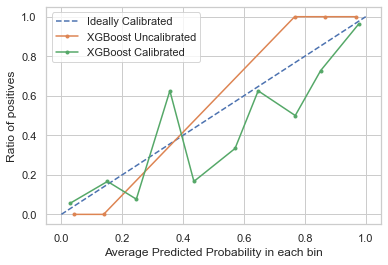

In [20]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.2, random_state=5)
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)
calibrated.fit(xtrain, ytrain)
probs = calibrated.predict_proba(xtest)[:, 1]
uncalibrated = xgb.predict_proba(xtest)[:,1]
fop_uncalibrated, mpv_uncalibrated = calibration_curve(ytest, uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(ytest, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Ideally Calibrated')
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label = 'XGBoost Uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label = 'XGBoost Calibrated')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

In [21]:
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)

scores_accuracy = cross_val_score(calibrated, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(calibrated, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(calibrated, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(calibrated, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(calibrated, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.872
XGBoost average log_loss is 0.316
XGBoost average brier score is 0.095
XGBoost average auc is 0.934
XGBoost average recall is 0.824
XGBoost average precision is 0.906
XGBoost average f1 is 0.849


In [35]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVC(random_state=5),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [36]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best Score is : 0.7808528712198438 


0.653 + or -0.113 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.751 + or -0.108 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.543 + or -0.049 for the {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.669 + or -0.128 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.593 + or -0.07 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.662 + or -0.125 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.619 + or -0.108 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.514 + or -0.028 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.617 + or -0.106 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.614 + or -0.104 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.514 + or -0.028 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.615 + or -0.104 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.751 + or -0.145 for the {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [26]:
svc = SVC(random_state=5, C = 100, gamma=1,kernel='rbf',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.781
SVC average log_loss is 0.484
SVC average brier score is 0.158
SVC average auc is 0.847
SVC average recall is 0.763
SVC average precision is 0.778
SVC average f1 is 0.761


In [10]:
#RFECV with Random Forest Input + Post admission variables
X = X_balanced[['Abnormal_Lung_Signs', 'Age', 'Average_Daily_Use_Cigarettes', 'BMI', 'CKD', 'Cancers',
                'DiastolicBP', 'Drug_history', 'Dyspnea', 'Fever', 'Hospitalization_14_days_ago',
                'Hypertension', 'ICU_admission', 'Intubation_Duration_Day', 'Oxygen_Saturation_Percent',
                'Pantoprazole', 'Respiratory_rate', 'SystolicBP']]
Y = Y_balanced

In [39]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel(), verbose=1)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [40]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300}
Best Score is : 0.90067957866123 


0.871 + or -0.107 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.879 + or -0.103 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.875 + or -0.102 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.875 + or -0.098 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.878 + or -0.098 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.884 + or -0.094 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.887 + or -0.086 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.887 + or -0.084 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_de

In [11]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=300,
                   max_depth = 8, learning_rate = 0.1, colsample_bytree = 0.5)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.901
XGBoost average log_loss is 0.282
XGBoost average brier score is 0.080
XGBoost average auc is 0.945
XGBoost average recall is 0.897
XGBoost average precision is 0.904
XGBoost average f1 is 0.897


C:\Users\alish\anaconda3\lib\site-packages\sklearn\calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


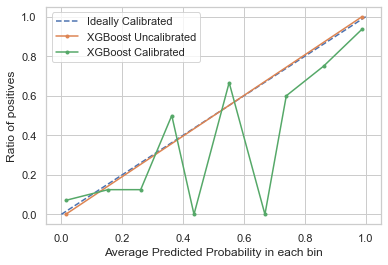

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.2, random_state=5)
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)
calibrated.fit(xtrain, ytrain)
probs = calibrated.predict_proba(xtest)[:, 1]
uncalibrated = xgb.predict_proba(xtest)[:,1]
fop_uncalibrated, mpv_uncalibrated = calibration_curve(ytest, uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(ytest, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Ideally Calibrated')
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label = 'XGBoost Uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label = 'XGBoost Calibrated')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

In [13]:
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)

scores_accuracy = cross_val_score(calibrated, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(calibrated, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(calibrated, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(calibrated, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(calibrated, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.897
XGBoost average log_loss is 0.288
XGBoost average brier score is 0.081
XGBoost average auc is 0.944
XGBoost average recall is 0.886
XGBoost average precision is 0.904
XGBoost average f1 is 0.892


In [42]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVC(random_state=5),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [43]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score is : 0.8029221882432893 


0.764 + or -0.103 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.784 + or -0.105 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.443 + or -0.051 for the {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.743 + or -0.085 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.779 + or -0.1 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.739 + or -0.08 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.692 + or -0.142 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.633 + or -0.125 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.681 + or -0.153 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.681 + or -0.154 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.633 + or -0.125 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.681 + or -0.154 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.785 + or -0.106 for the {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [28]:
svc = SVC(random_state=5, C = 100, gamma=0.1,kernel='rbf',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.803
SVC average log_loss is 0.461
SVC average brier score is 0.140
SVC average auc is 0.868
SVC average recall is 0.789
SVC average precision is 0.811
SVC average f1 is 0.798


In [29]:
#Feature importance with Random Forest Input
X = X_balanced[["Age", "CKD", "Oxygen_Saturation_Percent" , "DiastolicBP" , "BMI", 
                "Hypertension", "Cancers", "Cardiovascular_Disease", "Hospitalization_14_days_ago" ,
                "Abnormal_Lung_Signs", "Average_Daily_Use_Cigarettes" , "Pantoprazole"]]
Y = Y_balanced

In [46]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel(), verbose=1)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [47]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 900}
Best Score is : 0.8415137614678899 


0.767 + or -0.064 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.767 + or -0.071 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.783 + or -0.076 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.782 + or -0.068 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.79 + or -0.07 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.784 + or -0.069 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.787 + or -0.069 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.791 + or -0.073 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_

In [40]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=900,
                   max_depth = 15, learning_rate = 0.01, colsample_bytree = 0.8)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.842
XGBoost average log_loss is 0.385
XGBoost average brier score is 0.120
XGBoost average auc is 0.909
XGBoost average recall is 0.849
XGBoost average precision is 0.837
XGBoost average f1 is 0.840


In [49]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVC(random_state=5),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [50]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best Score is : 0.7464746856948692 


0.553 + or -0.074 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.616 + or -0.062 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.57 + or -0.061 for the {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.567 + or -0.051 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.495 + or -0.036 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.543 + or -0.048 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.526 + or -0.046 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.495 + or -0.036 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.523 + or -0.046 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.523 + or -0.046 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.495 + or -0.036 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.523 + or -0.046 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.641 + or -0.066 for the {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [30]:
svc = SVC(random_state=5, C = 100, gamma=1,kernel='rbf',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.746
SVC average log_loss is 0.537
SVC average brier score is 0.180
SVC average auc is 0.804
SVC average recall is 0.744
SVC average precision is 0.744
SVC average f1 is 0.741


In [31]:
#Feature importance with Random Forest Input + Post admission variables
X = X_balanced[["Intubation_Duration_Day", "Cancers", "CKD", "ICU_admission", "DiastolicBP",
               "SystolicBP", "Oxygen_Saturation_Percent", "Hospitalization_14_days_ago", "Chestpain",
               "Antihypertensive_drug", "Sweating", "BMI", "Cardiovascular_Disease", "Pantoprazole", 
               "Current_Smoking", "Average_Daily_Use_Cigarettes"]]
Y = Y_balanced

In [53]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel(), verbose=1)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [54]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 700}
Best Score is : 0.8961009174311927 


0.882 + or -0.109 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.872 + or -0.109 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.866 + or -0.118 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.867 + or -0.111 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.869 + or -0.1 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.885 + or -0.103 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.88 + or -0.104 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.877 + or -0.101 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_de

In [43]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=700,
                   max_depth = 8, learning_rate = 0.01, colsample_bytree = 0.3)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.896
XGBoost average log_loss is 0.292
XGBoost average brier score is 0.085
XGBoost average auc is 0.937
XGBoost average recall is 0.857
XGBoost average precision is 0.924
XGBoost average f1 is 0.884


In [56]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVC(random_state=5),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [57]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best Score is : 0.8380224260958207 


0.781 + or -0.114 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.801 + or -0.104 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.466 + or -0.034 for the {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.737 + or -0.081 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.766 + or -0.096 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.734 + or -0.079 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.679 + or -0.152 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.586 + or -0.098 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.678 + or -0.153 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.678 + or -0.153 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.586 + or -0.098 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.678 + or -0.153 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.807 + or -0.109 for the {'C': 1, 'gamma': 1, 'kernel': 'rbf'

In [32]:
svc = SVC(random_state=5, C = 100, gamma=1,kernel='rbf',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.838
SVC average log_loss is 0.382
SVC average brier score is 0.121
SVC average auc is 0.897
SVC average recall is 0.800
SVC average precision is 0.861
SVC average f1 is 0.828


In [11]:
#Feature Importance Gradient Boosting
X = X_balanced[["Age" , "Oxygen_Saturation_Percent", "CKD","Respiratory_rate", "DiastolicBP", 
                "SystolicBP","BMI", "Average_Daily_Use_Cigarettes" , "Pantoprazole", "Cancers",
                "Hypertension", "Abnormal_Lung_Signs", "Drug_history", "Sex", 
                "Total_Lung_Involvement_Percent", "Hospitalization_14_days_ago",
                "Current_Smoking", "Cardiovascular_Disease", "COPD", "Diabetes"]]
Y = Y_balanced

In [11]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel(), verbose=1)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [12]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 500}
Best Score is : 0.8794002718314644 


0.825 + or -0.096 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.84 + or -0.102 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.84 + or -0.099 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.84 + or -0.093 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.845 + or -0.092 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.844 + or -0.107 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.849 + or -0.1 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.851 + or -0.104 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_dep

In [12]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=500,
                   max_depth = 15, learning_rate = 0.01, colsample_bytree = 0.3)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.879
XGBoost average log_loss is 0.335
XGBoost average brier score is 0.100
XGBoost average auc is 0.943
XGBoost average recall is 0.855
XGBoost average precision is 0.900
XGBoost average f1 is 0.869


Hospitalization_14_days_ago       0.256842
Current_Smoking                   0.221461
Sex                               0.096378
Diabetes                          0.047521
CKD                               0.036033
Age                               0.035176
COPD                              0.030513
Average_Daily_Use_Cigarettes      0.029025
Cancers                           0.027644
Total_Lung_Involvement_Percent    0.026364
Oxygen_Saturation_Percent         0.025821
BMI                               0.023464
SystolicBP                        0.021302
DiastolicBP                       0.020840
Respiratory_rate                  0.020507
Drug_history                      0.018210
Cardiovascular_Disease            0.016722
Hypertension                      0.016135
Pantoprazole                      0.015326
Abnormal_Lung_Signs               0.014718
dtype: float32

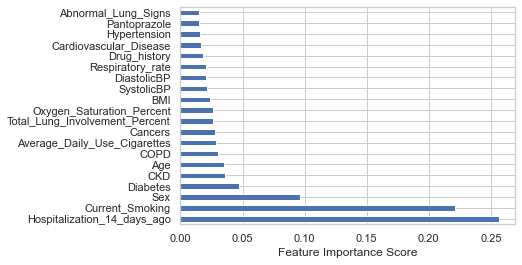

In [13]:
ft_importance = pd.Series(xgb.feature_importances_, index = X.columns)
ft_importance.nlargest(20).plot(kind="barh")
plt.xlabel("Feature Importance Score")
ft_importance.nlargest(20)

In [14]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


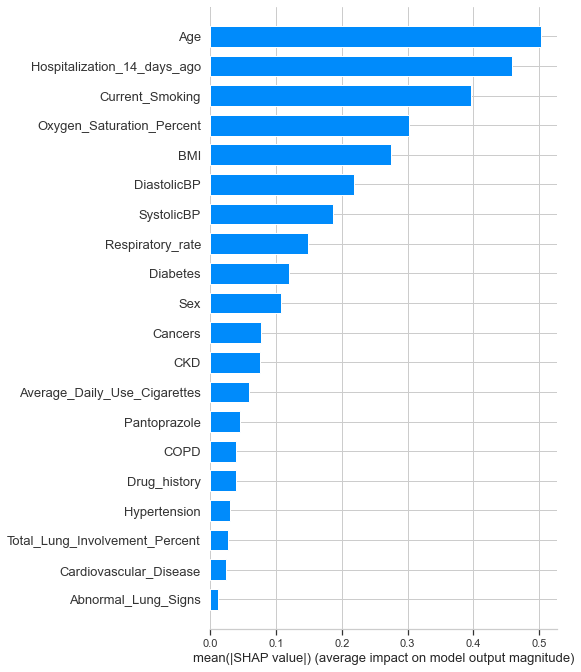

In [15]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar',max_display=33)

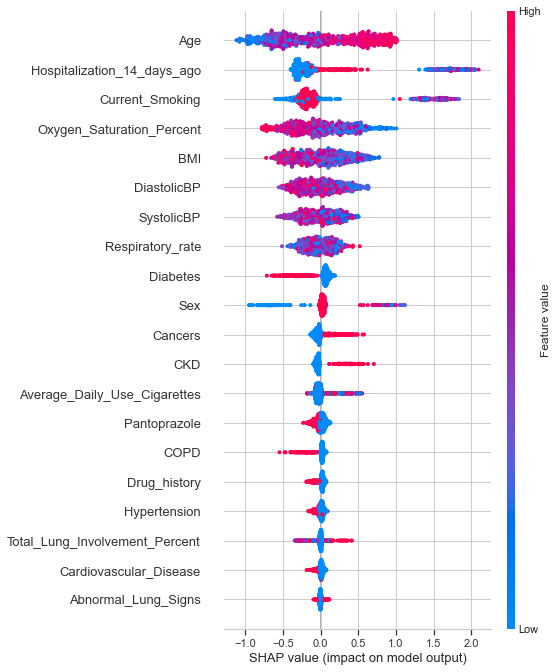

In [16]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns,max_display=33)

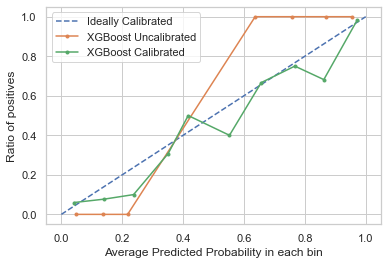

In [17]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.2, random_state=5)
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)
calibrated.fit(xtrain, ytrain)
probs = calibrated.predict_proba(xtest)[:, 1]
uncalibrated = xgb.predict_proba(xtest)[:,1]
fop_uncalibrated, mpv_uncalibrated = calibration_curve(ytest, uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(ytest, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Ideally Calibrated')
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label = 'XGBoost Uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label = 'XGBoost Calibrated')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

In [18]:
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)

scores_accuracy = cross_val_score(calibrated, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(calibrated, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(calibrated, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(calibrated, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(calibrated, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.877
XGBoost average log_loss is 0.308
XGBoost average brier score is 0.093
XGBoost average auc is 0.941
XGBoost average recall is 0.837
XGBoost average precision is 0.909
XGBoost average f1 is 0.863


In [19]:
y_pred = cross_val_predict(calibrated, X, Y, cv=10)

conf_mat = confusion_matrix(Y, y_pred)

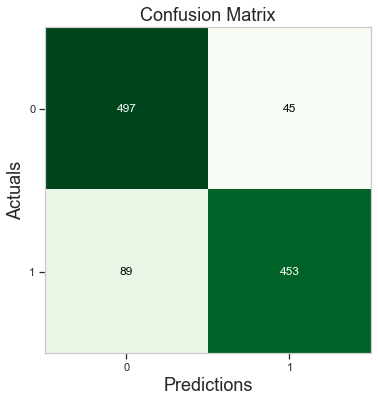

In [20]:
fig, ax = plot_confusion_matrix(conf_mat, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [21]:
DS = X
DS["actual"] = Y
DS["predicted"] = y_pred
incorrect = DS[DS["actual"] != DS["predicted"]]
incorrect.to_csv("At admission classification error cases.csv", index=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVC(random_state=5),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [15]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best Score is : 0.7881073734284744 


0.625 + or -0.105 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.749 + or -0.073 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.55 + or -0.037 for the {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.606 + or -0.068 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.551 + or -0.058 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.601 + or -0.059 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.572 + or -0.068 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.544 + or -0.062 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.573 + or -0.069 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.573 + or -0.069 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.544 + or -0.062 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.573 + or -0.069 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.693 + or -0.099 for the {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [35]:
svc = SVC(random_state=5, C = 100, gamma=1,kernel='rbf',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.788
SVC average log_loss is 0.463
SVC average brier score is 0.151
SVC average auc is 0.859
SVC average recall is 0.776
SVC average precision is 0.787
SVC average f1 is 0.777


C:\Users\alish\anaconda3\lib\site-packages\sklearn\calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


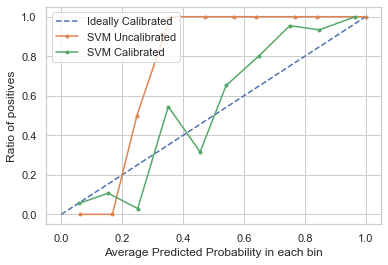

In [36]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.2, random_state=5)
calibrated = CalibratedClassifierCV(svc, method='sigmoid', cv=10)
calibrated.fit(xtrain, ytrain)
probs = calibrated.predict_proba(xtest)[:, 1]
uncalibrated = svc.decision_function(xtest)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(ytest, uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(ytest, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Ideally Calibrated')
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label = 'SVM Uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label = 'SVM Calibrated')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

In [37]:
calibrated = CalibratedClassifierCV(svc, method='sigmoid', cv=10)

scores_accuracy = cross_val_score(calibrated, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(calibrated, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(calibrated, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(calibrated, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(calibrated, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.786
SVC average log_loss is 0.467
SVC average brier score is 0.152
SVC average auc is 0.859
SVC average recall is 0.730
SVC average precision is 0.813
SVC average f1 is 0.761


In [38]:
#Feature Importance Gradient Boosting + Post admission variables
X = X_balanced[["ICU_admission", "Age", "Intubation_Duration_Day", "Oxygen_Saturation_Percent", "CKD", 
               "Cancers", "Respiratory_rate", "SystolicBP", "DiastolicBP", "BMI", "Average_Daily_Use_Cigarettes",
               "Drug_history", "Abnormal_Lung_Signs", "COPD", "Sweating", "Total_Lung_Involvement_Percent", 
                "Chestpain", "Cardiovascular_Disease", "Sex", "Hospitalization_14_days_ago"]]
Y = Y_balanced

In [18]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [19]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
Best Score is : 0.9024804621134896 


0.87 + or -0.115 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.876 + or -0.103 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.88 + or -0.108 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.881 + or -0.111 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.88 + or -0.107 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.88 + or -0.101 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.886 + or -0.096 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.881 + or -0.102 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_de

In [19]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=500,
                   max_depth = 10, learning_rate = 0.01, colsample_bytree = 0.5)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.902
XGBoost average log_loss is 0.255
XGBoost average brier score is 0.075
XGBoost average auc is 0.950
XGBoost average recall is 0.883
XGBoost average precision is 0.919
XGBoost average f1 is 0.896


C:\Users\alish\anaconda3\lib\site-packages\sklearn\calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


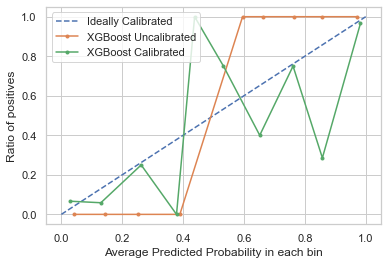

In [20]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.2, random_state=5)
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)
calibrated.fit(xtrain, ytrain)
probs = calibrated.predict_proba(xtest)[:, 1]
uncalibrated = xgb.predict_proba(xtest)[:,1]
fop_uncalibrated, mpv_uncalibrated = calibration_curve(ytest, uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(ytest, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Ideally Calibrated')
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label = 'XGBoost Uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label = 'XGBoost Calibrated')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

In [21]:
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)

scores_accuracy = cross_val_score(calibrated, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(calibrated, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(calibrated, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(calibrated, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(calibrated, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.897
XGBoost average log_loss is 0.266
XGBoost average brier score is 0.076
XGBoost average auc is 0.948
XGBoost average recall is 0.872
XGBoost average precision is 0.916
XGBoost average f1 is 0.889


In [21]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVC(random_state=5),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [22]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best Score is : 0.8407917091403331 


0.789 + or -0.113 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.804 + or -0.103 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.498 + or -0.006 for the {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.739 + or -0.082 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.768 + or -0.095 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.743 + or -0.088 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.692 + or -0.158 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.549 + or -0.081 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.69 + or -0.161 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.69 + or -0.161 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.549 + or -0.081 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.69 + or -0.161 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.818 + or -0.106 for the {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0

In [39]:
svc = SVC(random_state=5, C = 100, gamma=1,kernel='rbf',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.841
SVC average log_loss is 0.389
SVC average brier score is 0.121
SVC average auc is 0.894
SVC average recall is 0.831
SVC average precision is 0.845
SVC average f1 is 0.836


C:\Users\alish\anaconda3\lib\site-packages\sklearn\calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


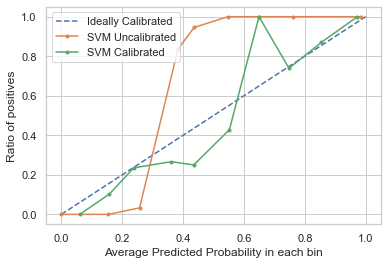

In [40]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.2, random_state=5)
calibrated = CalibratedClassifierCV(svc, method='sigmoid', cv=10)
calibrated.fit(xtrain, ytrain)
probs = calibrated.predict_proba(xtest)[:, 1]
uncalibrated = svc.decision_function(xtest)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(ytest, uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(ytest, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Ideally Calibrated')
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label = 'SVM Uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label = 'SVM Calibrated')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

In [41]:
calibrated = CalibratedClassifierCV(svc, method='sigmoid', cv=10)

scores_accuracy = cross_val_score(calibrated, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(calibrated, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(calibrated, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(calibrated, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(calibrated, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.839
SVC average log_loss is 0.390
SVC average brier score is 0.121
SVC average auc is 0.896
SVC average recall is 0.804
SVC average precision is 0.863
SVC average f1 is 0.830


In [42]:
#Physician Opinion Input 
X = X_balanced[["Age", "BMI", "SystolicBP", "DiastolicBP", "Respiratory_rate",
            "Oxygen_Saturation_Percent", "Total_Lung_Involvement_Percent", 
            "Sex", "Current_Smoking", "History_hookah", "Drug_history", "Fever", "Dyspnea", "Chestpain", 
            "Diabetes", "Hypertension", "Cancers", "Cardiovascular_Disease", "CKD", "COPD", "Immunosuppressant_Drugs"]]
Y = Y_balanced

In [25]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel(), verbose=1)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [26]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 300}
Best Score is : 0.8674991505266736 


0.814 + or -0.118 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.828 + or -0.116 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.826 + or -0.111 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.824 + or -0.113 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.827 + or -0.112 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.831 + or -0.111 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.836 + or -0.107 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.835 + or -0.104 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'ma

In [23]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=300,
                   max_depth = 15, learning_rate = 0.01, colsample_bytree = 0.5)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.867
XGBoost average log_loss is 0.366
XGBoost average brier score is 0.109
XGBoost average auc is 0.929
XGBoost average recall is 0.872
XGBoost average precision is 0.860
XGBoost average f1 is 0.864


C:\Users\alish\anaconda3\lib\site-packages\sklearn\calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


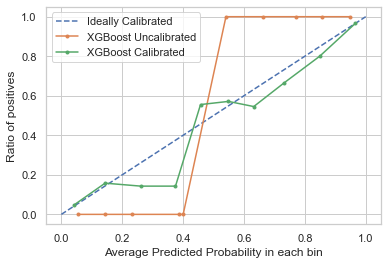

In [24]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.2, random_state=5)
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)
calibrated.fit(xtrain, ytrain)
probs = calibrated.predict_proba(xtest)[:, 1]
uncalibrated = xgb.predict_proba(xtest)[:,1]
fop_uncalibrated, mpv_uncalibrated = calibration_curve(ytest, uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(ytest, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Ideally Calibrated')
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label = 'XGBoost Uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label = 'XGBoost Calibrated')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

In [25]:
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)

scores_accuracy = cross_val_score(calibrated, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(calibrated, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(calibrated, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(calibrated, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(calibrated, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.859
XGBoost average log_loss is 0.329
XGBoost average brier score is 0.100
XGBoost average auc is 0.927
XGBoost average recall is 0.837
XGBoost average precision is 0.870
XGBoost average f1 is 0.849


In [28]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVC(random_state=5),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [29]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
Best Score is : 0.7760703363914374 


0.689 + or -0.119 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.776 + or -0.092 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.536 + or -0.045 for the {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.666 + or -0.127 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.577 + or -0.056 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.65 + or -0.133 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.617 + or -0.108 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.52 + or -0.025 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.616 + or -0.109 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.615 + or -0.109 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.52 + or -0.025 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.615 + or -0.109 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.729 + or -0.125 for the {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [43]:
svc = SVC(random_state=5, C = 0.1, gamma=1,kernel='poly',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.776
SVC average log_loss is 0.536
SVC average brier score is 0.171
SVC average auc is 0.826
SVC average recall is 0.839
SVC average precision is 0.743
SVC average f1 is 0.785


C:\Users\alish\anaconda3\lib\site-packages\sklearn\calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


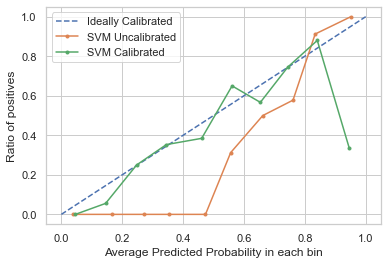

In [44]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.2, random_state=5)
calibrated = CalibratedClassifierCV(svc, method='sigmoid', cv=10)
calibrated.fit(xtrain, ytrain)
probs = calibrated.predict_proba(xtest)[:, 1]
uncalibrated = svc.decision_function(xtest)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(ytest, uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(ytest, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Ideally Calibrated')
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label = 'SVM Uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label = 'SVM Calibrated')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

In [45]:
calibrated = CalibratedClassifierCV(svc, method='sigmoid', cv=10)

scores_accuracy = cross_val_score(calibrated, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(calibrated, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(calibrated, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(calibrated, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(calibrated, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.762
SVC average log_loss is 0.519
SVC average brier score is 0.169
SVC average auc is 0.828
SVC average recall is 0.783
SVC average precision is 0.748
SVC average f1 is 0.763


In [12]:
#Physician Opinion Input + Post admission variables
X = X_balanced[["Age", "BMI", "SystolicBP", "DiastolicBP", "Respiratory_rate",
            "Oxygen_Saturation_Percent", "Total_Lung_Involvement_Percent", 
            "Sex", "Current_Smoking", "History_hookah", "Drug_history", "Fever", "Dyspnea", "Chestpain", 
            "Diabetes", "Hypertension", "Cancers", "Cardiovascular_Disease", "CKD", "COPD", "Immunosuppressant_Drugs",
            'Intubation_Duration_Day','NIV_Duration_Day',"ICU_admission"]]
Y = Y_balanced

In [35]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

params = {
    "max_depth": [ 3, 4, 6, 8, 10, 15],
    'n_estimators': range(100,1000,200),
    'learning_rate': [0.1,0.01,0.001],
    "colsample_bytree" : [0.3, 0.5 , 0.8]
}

cv = GridSearchCV(xgb,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel(), verbose=1)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 6, 8, 10, 15],
                         'n_estimators': range(100, 1000, 200)},
             verbose=1)

In [36]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 300}
Best Score is : 0.9089874277947672 


0.875 + or -0.114 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.878 + or -0.11 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.881 + or -0.115 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.88 + or -0.115 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
0.881 + or -0.119 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 900}
0.877 + or -0.127 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.88 + or -0.125 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.887 + or -0.124 for the {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_d

In [13]:
xgb = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42, n_estimators=300,
                   max_depth = 15, learning_rate = 0.01, colsample_bytree = 0.3)
xgb.fit(X,Y)

scores_accuracy = cross_val_score(xgb, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(xgb, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(xgb, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(xgb, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(xgb, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(xgb, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(xgb, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.908
XGBoost average log_loss is 0.316
XGBoost average brier score is 0.088
XGBoost average auc is 0.954
XGBoost average recall is 0.887
XGBoost average precision is 0.923
XGBoost average f1 is 0.901


ICU_admission                     0.327618
Intubation_Duration_Day           0.232332
Current_Smoking                   0.068734
Chestpain                         0.068146
Sex                               0.041510
Fever                             0.029823
NIV_Duration_Day                  0.024509
Immunosuppressant_Drugs           0.018717
Diabetes                          0.018254
History_hookah                    0.017790
CKD                               0.016698
Dyspnea                           0.016264
Age                               0.015969
COPD                              0.013612
Total_Lung_Involvement_Percent    0.011098
Oxygen_Saturation_Percent         0.010462
Cancers                           0.009538
BMI                               0.009485
DiastolicBP                       0.009305
Drug_history                      0.009027
dtype: float32

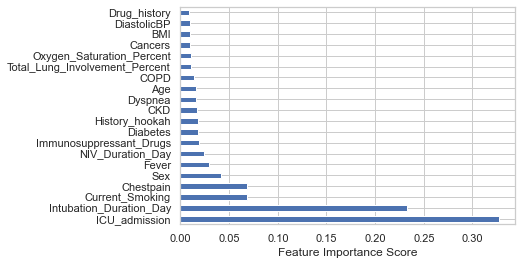

In [14]:
ft_importance = pd.Series(xgb.feature_importances_, index = X.columns)
ft_importance.nlargest(20).plot(kind="barh")
plt.xlabel("Feature Importance Score")
ft_importance.nlargest(20)

In [15]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)
shap.initjs()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


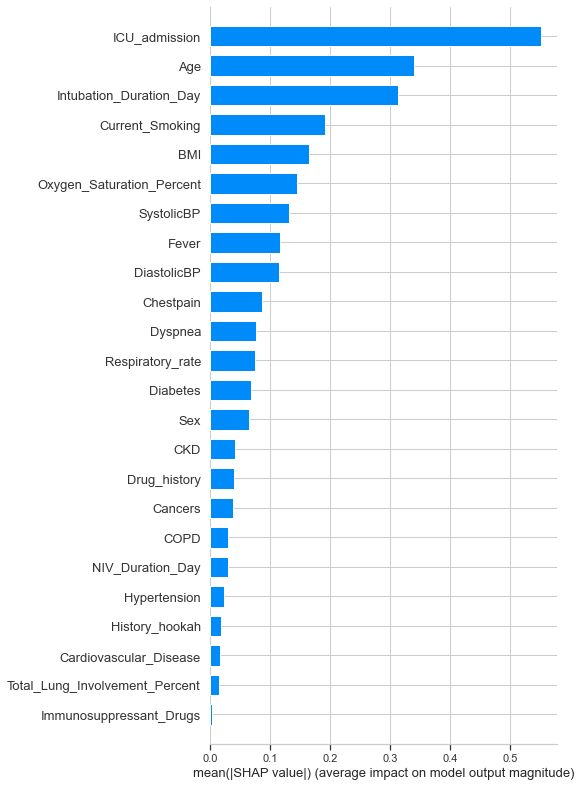

In [16]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar',max_display=33)

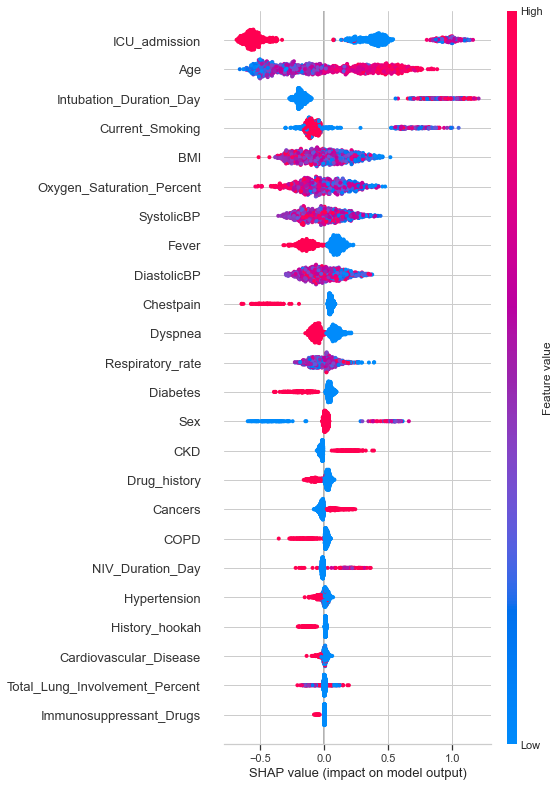

In [17]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns,max_display=33)

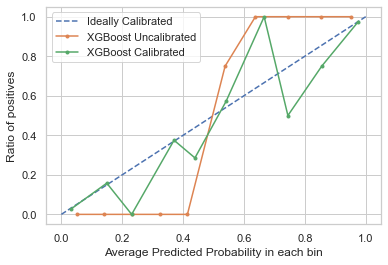

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.2, random_state=5)
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)
calibrated.fit(xtrain, ytrain)
probs = calibrated.predict_proba(xtest)[:, 1]
uncalibrated = xgb.predict_proba(xtest)[:,1]
fop_uncalibrated, mpv_uncalibrated = calibration_curve(ytest, uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(ytest, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Ideally Calibrated')
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label = 'XGBoost Uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label = 'XGBoost Calibrated')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

In [19]:
calibrated = CalibratedClassifierCV(xgb, method='sigmoid', cv=10)

scores_accuracy = cross_val_score(calibrated, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(calibrated, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(calibrated, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(calibrated, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(calibrated, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(calibrated, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("XGBoost average accuracy is %2.3f" % scores_accuracy.mean())
print("XGBoost average log_loss is %2.3f" % -scores_log_loss.mean())
print("XGBoost average brier score is %2.3f" % -scores_briar.mean())
print("XGBoost average auc is %2.3f" % scores_auc.mean())
print("XGBoost average recall is %2.3f" % scores_recall.mean())
print("XGBoost average precision is %2.3f" % scores_precision.mean())
print("XGBoost average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
XGBoost average accuracy is 0.905
XGBoost average log_loss is 0.244
XGBoost average brier score is 0.071
XGBoost average auc is 0.952
XGBoost average recall is 0.881
XGBoost average precision is 0.922
XGBoost average f1 is 0.897


In [66]:
y_pred = cross_val_predict(calibrated, X, Y, cv=10)

conf_mat = confusion_matrix(Y, y_pred)

In [67]:
conf_mat

array([[504,  38],
       [ 65, 477]], dtype=int64)

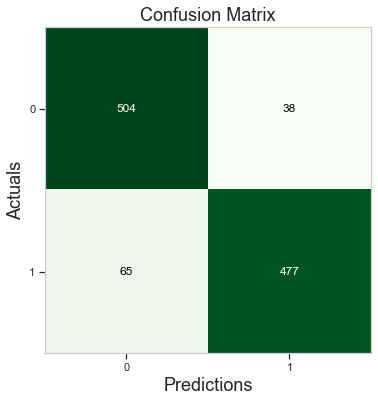

In [68]:
fig, ax = plot_confusion_matrix(conf_mat, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [74]:
DS = X
DS["actual"] = Y
DS["predicted"] = y_pred
incorrect = DS[DS["actual"] != DS["predicted"]]
incorrect.to_csv("Post admission classification error cases.csv", index=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
svc = SVC(random_state=5)

params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

cv = GridSearchCV(svc,params,cv=10, verbose=1)
cv.fit(X,Y.values.ravel())

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVC(random_state=5),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [39]:
def display_results(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best Score is : {results.best_score_} ')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display_results(cv)

Best parameters are: {'C': 100, 'gamma': 1, 'kernel': 'poly'}
Best Score is : 0.8157832144070676 


0.731 + or -0.14 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.803 + or -0.115 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.497 + or -0.005 for the {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.776 + or -0.09 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.778 + or -0.1 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.778 + or -0.107 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.723 + or -0.137 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.577 + or -0.07 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.694 + or -0.164 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.694 + or -0.164 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.577 + or -0.07 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.694 + or -0.164 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.79 + or -0.133 for the {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.80

In [40]:
svc = SVC(random_state=5, C = 100, gamma=1,kernel='poly',probability=True)
svc.fit(X,Y)

scores_accuracy = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(svc, X, Y, cv=10, scoring='neg_log_loss')
scores_briar = cross_val_score(svc, X, Y, cv=10, scoring='neg_brier_score')
scores_auc = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc')
scores_recall = cross_val_score(svc, X, Y, cv=10, scoring='recall')
scores_precision = cross_val_score(svc, X, Y, cv=10, scoring='precision')
scores_f1 = cross_val_score(svc, X, Y, cv=10, scoring='f1')
print('K-fold cross-validation results:')
print("SVC average accuracy is %2.3f" % scores_accuracy.mean())
print("SVC average log_loss is %2.3f" % -scores_log_loss.mean())
print("SVC average brier score is %2.3f" % -scores_briar.mean())
print("SVC average auc is %2.3f" % scores_auc.mean())
print("SVC average recall is %2.3f" % scores_recall.mean())
print("SVC average precision is %2.3f" % scores_precision.mean())
print("SVC average f1 is %2.3f" % scores_f1.mean())

K-fold cross-validation results:
SVC average accuracy is 0.816
SVC average log_loss is 0.501
SVC average brier score is 0.155
SVC average auc is 0.857
SVC average recall is 0.833
SVC average precision is 0.804
SVC average f1 is 0.816
